In [44]:
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# data from: https://www.kaggle.com/datasets/sohier/calcofi
df = pd.read_csv("bottle.csv")

In [6]:
df.head()

,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Create train and test data sets 80/20 split
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)


In [8]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Cst_Cnt,288467.0,6771.349777,4055.508100,1.00,3011.00,6947.000,10379.00,13519.00
Btl_Cnt,288467.0,180222.920698,104066.242945,1.00,90214.50,180109.000,270249.50,360583.00
Depthm,288467.0,265.766722,345.576153,0.00,50.00,140.000,365.00,5165.00
T_degC,283465.0,10.576866,4.579870,1.44,7.20,9.800,13.75,31.14
Salnty,259727.0,33.930184,0.473320,30.25,33.57,33.965,34.31,36.33
...,...,...,...,...,...,...,...,...
TA1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pH2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pH1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# predict temp based upon salinity
train_features = train_dataset[['Salnty', 'T_degC']]
test_features = test_dataset[['Salnty', 'T_degC']]

In [94]:
train_features.isna().sum()


Salnty    28740
T_degC     5002
dtype: int64

In [95]:
train_features = train_features.dropna()
test_features = test_features.dropna()

train_true = train_features.pop('T_degC')
test_true = test_features.pop('T_degC')

train_features.shape, test_features.shape, train_true.shape, test_true.shape

((257336, 1), (64382, 1), (257336,), (64382,))

In [143]:
train_true.describe()

count    257336.000000
mean         10.729051
std           4.573037
min           1.440000
25%           7.390000
50%           9.940000
75%          13.900000
max          31.140000
Name: T_degC, dtype: float64

In [97]:
train_features_salt = train_features[['Salnty']]


In [99]:
# test_array=np.array([[1,2,3,3,4,5],[2,3,3,4,5,500]])
# test_array=np.array([[1],[2],[3]])
# test_array.shape

In [100]:
# normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=1)
# normalizer.adapt(np.array(train_features_salt))
normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=1)
# normalizer.adapt(test_array)
normalizer.adapt(np.array(train_features_salt))


In [103]:
## Callbacks

# End training if no improvement seen
early_stop_callbk = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.05, patience=5)

# Optimize LR
opt_LR_callbk = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2
)



In [144]:
def get_basic_model():
  model = tf.keras.Sequential([
    normalizer,
    # tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mse'])
  return model

In [145]:
model_1 = get_basic_model()
history_1 = model_1.fit(train_features_salt, train_true, epochs=15, batch_size=32, validation_split=0.2, 
                callbacks=[early_stop_callbk, opt_LR_callbk])


Epoch 1/15
6434/6434 [==============================] - 17s 3ms/step - loss: 25.7894 - mse: 25.7894 - val_loss: 17.8645 - val_mse: 17.8645 - lr: 0.0100
Epoch 2/15
6434/6434 [==============================] - 17s 3ms/step - loss: 17.8361 - mse: 17.8361 - val_loss: 17.8686 - val_mse: 17.8686 - lr: 0.0100
Epoch 3/15
6434/6434 [==============================] - 16s 3ms/step - loss: 17.8347 - mse: 17.8347 - val_loss: 17.8402 - val_mse: 17.8402 - lr: 0.0100
Epoch 4/15
6434/6434 [==============================] - 20s 3ms/step - loss: 17.8369 - mse: 17.8369 - val_loss: 17.8422 - val_mse: 17.8422 - lr: 0.0100
Epoch 5/15
6434/6434 [==============================] - 17s 3ms/step - loss: 17.8357 - mse: 17.8357 - val_loss: 17.8411 - val_mse: 17.8411 - lr: 0.0100
Epoch 6/15
6434/6434 [==============================] - 16s 3ms/step - loss: 17.8284 - mse: 17.8284 - val_loss: 17.8430 - val_mse: 17.8430 - lr: 1.0000e-03


In [146]:
hist_1_df = pd.DataFrame(history_1.history)
hist_1_df.head()

,loss,mse,val_loss,val_mse,lr
0,25.789429,25.789429,17.864491,17.864491,0.01
1,17.836105,17.836105,17.868574,17.868574,0.01
2,17.834669,17.834669,17.840240,17.840240,0.01
3,17.836855,17.836855,17.842175,17.842175,0.01
4,17.835691,17.835691,17.841114,17.841114,0.01


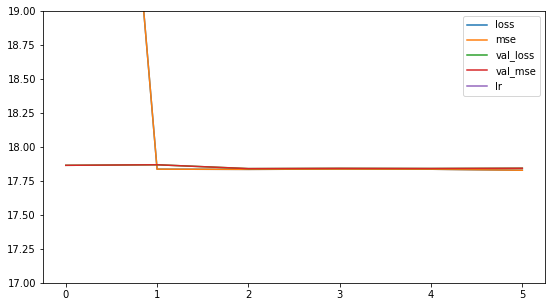

In [147]:
hist_1_df.plot(figsize=(9,5), ylim=(17,19))

In [148]:
test_features.shape

(64382, 1)

In [149]:
# make predictions on test data
y_pred = model_1.predict(test_features)

In [150]:
y_pred

array([[12.589944],
       [12.662012],
       [10.313758],
       ...,
       [11.262165],
       [11.250791],
       [10.199953]], dtype=float32)

In [151]:
y_pred.shape

(64382, 1)

In [152]:
y_true = np.array(test_true)
y_true= np.expand_dims(y_true, axis=1)
y_true.shape


(64382, 1)

In [153]:
# Measure MSE & MAE of predicitons vs. actual
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()

mse(y_true, y_pred).numpy(), mae(y_true, y_pred).numpy()


(17.739466, 3.2200587)

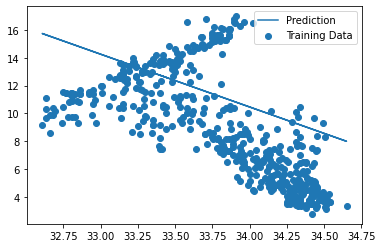

In [157]:
plt.scatter(test_features[:500], y_true[:500], label="Training Data")
plt.plot(test_features[:500], y_pred[:500], label="Prediction")
plt.legend()